# "Revisiting Brown patch dataset and benchmark"
> "How to create useful development set"
- toc: false
- image: images/brown_phototour_revisited.jpg
- branch: master
- badges: true
- comments: true
- hide: false
- search_exclude: false

### In this post

1. Why one needs good development set? What is wrong with existing sets for local patch descriptor learning?
2. One should validate in the same way, as it is used in production.
3. Brown patch revisited -- implementation details
4. Local patch descriptors evaluation results.

## Really quick intro into local patch descriptors



Local patch descriptor is the thing, which helps you to automatically decide, if two patches in the pair of images correspond to the same point in a real world, or not. It should be robust to illumination, viewpoint and other changes. 

![](2020-09-16-local-descriptors-validation_files/att_00003.png "The task of local descriptor, neural network here, is to decide if two patches belong to the same point, or nor. Image taken from SoSNet decriptor blogpost by Vassileios Balntas https://medium.com/scape-technologies/mapping-the-world-part-4-sosnet-to-the-rescue-5383671713e7")

There are lots of ways how to implement a local patch descriptor: engineered and learned. 
Local patch descriptor is the crucial component of the [wide baseline stereo pipeline](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2020/03/27/intro.html) and a popular computer vision research topic.

## Why do you need development set?

Good data is crucial for any machine learning problem -- everyone now knows that. 
One needs high quality training set for training a good model. One also needs good test set, to know, what is _real_ performance. However, there is one more, often forgotten, crucial component -- **validation** or **development** set. We use it to decide hyperparameters and validate design choices we make. It should be different from both training and test sets, yet, be good predictor of test set performance.
Moreover, it should allow fast iterations, so be not too small. 

While such set is commonly called [validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets), I do like Andrew Ng's term "[development](https://cs230.stanford.edu/files/C2M1.pdf)" set more - because it helps to *develop* your model.


# Existing datasets for local patch descriptors
So, what are the development set options for local patch descriptors?


### Brown PhotoTourism.

![](2020-09-16-local-descriptors-validation_files/brown_patches.png "Patches from 3 subsets of Brown Phototourism dataset")

The most commonly and successfully used dataset for local descriptor learning is PhotoTourism, created in 2008. Here is its [description by authors](http://matthewalunbrown.com/patchdata/patchdata.html):


>The dataset consists of corresponding patches sampled from 3D reconstructions of the Statue of Liberty (New York), Notre Dame (Paris) and Half Dome (Yosemite).

It also comes with evaluation protocol: patch pairs are labeled as "same" or "different" and the false positive rate at recall of 95% (FPR95) is reported. The variable, used to build ROC curve is descriptor distance between two patches.

Advantages:

 - It contains local patches, extracted for two types of local feature detector -- DoG (SIFT) and Harris corners.
 - It is extracted from images, contraining non-planar structures and the geometrical noise present is caused by the local feature detector, not added artificially.  
 - Descriptors, trained on the dataset, show very good performance \cite{IMW2020}, therefore the data itself is good.


Disadvantages:

 - when used as a benchmark, it shows unrealistic results: SIFT is 40x worse than deep learned descriptor. In practice, the difference is much smaller.

### HPatches

[HPatches](https://github.com/hpatches/hpatches-dataset), where H stands for the "[homography](https://en.wikipedia.org/wiki/Homography)" was proposed to overcome the problem of unrealisting metric and, seemingly, too easy data, used in Phototourism dataset.

It was constructed in a different way than a Phototourism. First, local features were detected in the "reference" image and then reprojected to other images in sequences. Reprojection is prossible, because all the images are photographies of the planes  -- graffity, drawing, print, etc, or are all taken from the same position.
After the reprojection, some amount of geometrical noise -- rotation, translation, scaling, was added to the local features and the patches were extracted. 

This process is illustration on the picture below (both taken from the [HPatches website](https://github.com/hpatches/hpatches-dataset)).


![](2020-09-16-local-descriptors-validation_files/images_hard.png "Visualization of the hard patches locations in the target images.")
![](2020-09-16-local-descriptors-validation_files/patches_hard.png "Extracted hard patches from the example sequence.")


HPAtches also provide 3 testing protocol, evaluating mean average precision (mAP) for 3 different tasks: patch verification  -- similar to Brown Phototourism, image matching and patch retrieval. The variable, used to build mAP is descriptor distance between two patches.

Advantages:

 - Unlike PhotoTourism patch verification, image matching and patch retrieval tasks are not saturated.
 - HPatches contains illumination split, allowing the evaluation of descriptor robustness to illumination changes.
 
Disadvantages:

 - patches "misregistration" noise is of artificial nature, although paper claims that it has similar statistics
 - no non-planar structure
 - performance in HPaptches does not really correlate with the downstream performance \cite{IMW2020}

![image.png](2020-09-16-local-descriptors-validation_files/hpatches_vs_IMC.png "Performance in HPaptches does not really correlate with the downstream performance on the Image Matching Benchmark")

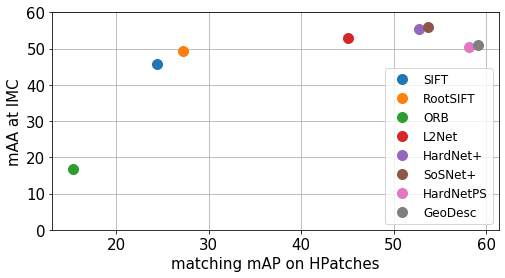

In [30]:
#hide
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (8,4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# From https://arxiv.org/pdf/1904.05019.pdf
results_hp = {}
results_hp['SIFT'] = 24.42
results_hp['RootSIFT'] =27.22
results_hp['ORB'] = 15.32

results_hp['L2Net'] = 45.04
results_hp['HardNet+'] = 52.76
results_hp['SoSNet+'] = 53.75
results_hp['HardNetPS'] = 58.16
results_hp['GeoDesc'] = 59.15


results_IMC = {}
results_IMC['ORB'] = 16.74
results_IMC['SIFT'] = 45.84
results_IMC['RootSIFT'] = 49.30
results_IMC['L2Net'] = 52.95

results_IMC['HardNet+'] = 55.43
results_IMC['HardNetPS'] = 50.51
results_IMC['SoSNet+'] = 55.87 
results_IMC['GeoDesc'] = 51.11

leg = []
for k, v in results_hp.items():
    plt.plot(v, results_IMC[k], 'o', label=k, markersize=10)
    leg.append(k)
    
plt.legend(leg)
plt.xlabel('matching mAP on HPatches')
plt.ylabel('mAA at IMC')
plt.ylim([0,60.])
plt.grid('on')

### AMOSPatches

[AMOS patches](https://github.com/pultarmi/AMOS_patches) is "HPatches illumination on steroids, without geometrical noise". It has the same advantanges and disadvantages, as HPatches and is mostly focused on illumination and weather changes.


![](2020-09-16-local-descriptors-validation_files/att_00002.png "Some images, contributing to AMOSPatches")
![](2020-09-16-local-descriptors-validation_files/amos_patches_small.png "Some patches from AMOS Patches dataset")



### PhotoSynth


[PhotoSynth](https://github.com/rmitra/PS-Dataset) can be described and something in the middle between Phototour and HPatches. It contains patches, sampled from planar scenes, as well as from non-planar scenes. 

At first glance, it should be great for the test and training purposes. However, there are several issues with it.
First, pre-trained HardNetPS descriptor, released together with the dataset, works well on HPatches, but poor in practice\cite{pultar2020improving}. 

Second, a couple of colleagues has tried to train the descriptor on top of it, as it was significantly worse than the authors reference model. Moreover, there is no testing/training code protocol available together with dataset.

So, while PhotoSynth might be a good dataset in principle, it definitely needs more love and work.

![image.png](2020-09-16-local-descriptors-validation_files/att_00000.png "Images, contributed to PS dataset")

![image.png](2020-09-16-local-descriptors-validation_files/att_00001.png "Patches, samples from PS dataset")

## Designing the evaluation protocol

Classical local descriptor matching consists of two parts: finding nearest neighbors and filtering unreliable ones based on some criterion. 
I have wrote a [blogpost, describing the matching strategies in details](https://medium.com/@ducha.aiki/how-to-match-to-learn-or-not-to-learn-part-2-1ab52ede2022).


The most used in practice criterion is the first to second nearest neighbor distance (Lowe's) ratio threshold for filtering false positive matches. It is shown in the figure below. 

The intuition is simple: if two candidates are too similar, then the match is unreliable and it is better to drop it.

![](2020-09-16-local-descriptors-validation_files/att_00004.png "Second nearest ratio strategy. Features from img1  -- blue circles -- are matched to features from img2  -- red squares. For each point in img1 we calculate two nearest neighbors and check their distance ratio . If both are too similar, i.e. >0.8, bottom at Figure, then the match is discarded. Only confident matches are kept. Right graph is from SIFT paper, justification of such strategy.")

Somehow, none of the local patch evaluation protocols does not take such filtering criterion in mind, although it greatly influences the overall performance. 

So, let's do the following:

1. Take the patches, which are extracted from only two images. 
2. For the each patch, calculate the descriptor distance to the correct match and to the hardnest (closest) non-match. Calculate the Lowe's ratio between this two.
3. Calculate accuracy for each of such triplets. If the correct match has smaller distance, score 1, if not - 0.
4. Sort the ratios from smallest to biggest and calculate [mean average precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) (mAP).

## Brown PhotoTour Revisied: implementation details


We have designed the protocol, now time for data. We could spend several month collecting and cleaning it...or we can just re-use great Brown PhotoTourism dataset. Re-visiting labeling and/or evaluation protocol of the time-tested dataset is a great idea. 

Just couple of examples: [ImageNette](https://github.com/fastai/imagenette) created by [Jeremy Howard](https://twitter.com/jeremyphoward) from ImageNet, [Revisited Oxford 5k](http://cmp.felk.cvut.cz/revisitop/) by [Filip Radenovic](https://filipradenovic.github.io/) and so on.

For the protocol we designed above we need the information about the image id, where the patch was extracted from. Unfortunately, there is no such information in the Brown PhotoTourism, but there is suitable alternative -- the image id, where the reference patch was detected. What does it mean?

Suppose, we have 4 images and 5 keypoints. All the keypoints present in all images, which gives us 20 patches.
3 keypoints were first detected in Image 1 and 2 in image 2.  
That means that we will have 12 patches labeled image 1 and 8 patches labeled image 2. 

So, we will have results for image 1 and image 2. Let's consider image 1. There are 12 patches, splitted in 3 "classes", 4 patches in each class. 

Then, for the each of those 12 patches we:

- pick each of the corresponding patched as positives, so 3 positives. $P_1$, $P_2$, $P_3$
- find the closest negative N. 
- add triplets (A, $P_1$, N), (A, $P_2$, N), (A, $P_3$, N) to the evaluation.

Repeat the same for the image 2. 
That mimics the two-view matching process as close, as possible, given the data available to us.

## Installation

`pip install brown_phototour_revisited`

## How to use

There is a single function, which does everything for you: `full_evaluation`. The original Brown benchmark consider evaluation, similar to cross-validation: train descriptor on one subset, evaluate on two others, repeat for all, so 6 evaluations are required. For the handcrafted descriptors, or those, that are trained on 3rd party datasets, only 3 evaluations are necessary.  We are following it here as well.

However, if you need to run some tests separately, or reuse some functions -- we will cover the usage below.
In the following example we will show how to use `full_evaluation` to evaluate SIFT descriptor as implemented in kornia.

```
# !pip install kornia
```

```
import torch
import kornia
from IPython.display import clear_output
from brown_phototour_revisited.benchmarking import *
patch_size = 65 

model = kornia.feature.SIFTDescriptor(patch_size, rootsift=True).eval()

descs_out_dir = 'data/descriptors'
download_dataset_to = 'data/dataset'
results_dir = 'data/mAP'

results_dict = {}
results_dict['Kornia RootSIFT'] = full_evaluation(model,
                                'Kornia RootSIFT',
                                path_to_save_dataset = download_dataset_to,
                                path_to_save_descriptors = descs_out_dir,
                                path_to_save_mAP = results_dir,
                                patch_size = patch_size, 
                                device = torch.device('cuda:0'), 
                           distance='euclidean',
                           backend='pytorch-cuda')
clear_output()
print_results_table(results_dict)
```

    ------------------------------------------------------------------------------
    Mean Average Precision wrt Lowe SNN ratio criterion on UBC Phototour Revisited
    ------------------------------------------------------------------------------
    trained on       liberty notredame  liberty yosemite  notredame yosemite
    tested  on           yosemite           notredame            liberty
    ------------------------------------------------------------------------------
    Kornia RootSIFT        56.70              47.71               48.09 
    ------------------------------------------------------------------------------

## Results

So, let's check how it goes. The latest results and implementation are in the following notebooks:

- [Deep descriptors](https://github.com/ducha-aiki/brown_phototour_revisited/blob/master/examples/evaluate_deep_descriptors.ipynb)
- [Non-deep descriptors](https://github.com/ducha-aiki/brown_phototour_revisited/blob/master/examples/evaluate_non_deep_descriptors.ipynb)

The results are the following:


    ------------------------------------------------------------------------------
    Mean Average Precision wrt Lowe SNN ratio criterion on UBC Phototour Revisited
    ------------------------------------------------------------------------------
    trained on       liberty notredame  liberty yosemite  notredame yosemite
    tested  on           yosemite           notredame            liberty
    ------------------------------------------------------------------------------
    Kornia RootSIFT 32px   58.24              49.07               49.65 
    HardNet 32px       70.64  70.31        61.93  59.56        63.06  61.64
    SOSNet 32px        70.03  70.19        62.09  59.68        63.16  61.65
    TFeat 32px         65.45  65.77        54.99  54.69        56.55  56.24
    SoftMargin 32px    69.29  69.20        61.82  58.61        62.37  60.63
    HardNetPS 32px         55.56              49.70               49.12 
    R2D2_center_grayscal   61.47              53.18               54.98 
    R2D2_MeanCenter_gray   62.73              54.10               56.17 
    ------------------------------------------------------------------------------
    
    ------------------------------------------------------------------------------
    Mean Average Precision wrt Lowe SNN ratio criterion on UBC Phototour Revisited
    ------------------------------------------------------------------------------
    trained on       liberty notredame  liberty yosemite  notredame yosemite
    tested  on           yosemite           notredame            liberty
    ------------------------------------------------------------------------------
    Kornia SIFT 32px       58.47              47.76               48.70 
    OpenCV_SIFT 32px       53.16              45.93               46.00 
    Kornia RootSIFT 32px   58.24              49.07               49.65 
    OpenCV_RootSIFT 32px   53.50              47.16               47.37 
    OpenCV_LATCH 65px  -----  -----        -----  37.26        -----  39.08
    OpenCV_LUCID 32px      20.37              23.08               27.24 
    skimage_BRIEF 65px     52.68              44.82               46.56 
    Kornia RootSIFTPCA 3 60.73  60.64        50.80  50.24        52.46  52.02
    MKD-concat-lw-32 32p 72.27  71.95        60.88  58.78        60.68  59.10
    ------------------------------------------------------------------------------
    
So far - in agreement with IMC benchmark: SIFT and RootSIFT are good, but not the best, SOSNet and HardNet are the leaders, but within tens of percents, not by orders of magnitude.


![](2020-09-16-local-descriptors-validation_files/att_00005.png "Image Matching Benchmark results, from https://arxiv.org/abs/2003.01587")
    
    
### Disclaimer 1: don't trust this tables fully


I haven't (yet!) checked if all the deep descriptors models, trained on Brown, were trained with flip-rotation 90 degrees augmentation. In the code below I assume that they were, however, it might not be true -- and the comparison might not be completely fair. I will do my best to check it, but if you know that I have used wrong weights - please [open an issue](https://github.com/ducha-aiki/brown_phototour_revisited/issues). Thank you. 


### Disclaimer 2: it is not "benchmark".


The intended usage of the package is not to test and report the numbers in the paper. Instead think about is as cross-validation tool, helping the development. Thus, one CAN tune hyperparameters based on the benchmark results  instead of doing so on [HPatches](https://github.com/hpatches/hpatches-benchmark). After you have finished tuning, please, evaluate your local descriptors on some downstream task like [IMC image matching benchmark](https://github.com/vcg-uvic/image-matching-benchmark) or [visual localization](https://www.visuallocalization.net/).

## Summary

It really pays off, to spend time designing a proper evaluation pipeline and gathering the data for it. If you can re-use existing work - great. 
But don't blindly trust anything, even super-popular and widely adopted benchmarks. You need always check if the the protocol and data makes sense for your use-case personally. 

Thanks for the reading, see you soon!

## Citation

If you use the benchmark/development set in an academic work, please cite it.

    @misc{BrownRevisited2020,
      title={UBC PhotoTour Revisied},
      author={Mishkin, Dmytro},
      year={2020},
      url = {https://github.com/ducha-aiki/brown_phototour_revisited}
    }

# References

[<a id="cit-IMW2020" href="#call-IMW2020">IMW2020</a>] Jin Yuhe, Mishkin Dmytro, Mishchuk Anastasiia <em>et al.</em>, ``_Image Matching across Wide Baselines: From Paper to Practice_'', arXiv preprint arXiv:2003.01587, vol. , number , pp. ,  2020.

[<a id="cit-pultar2020improving" href="#call-pultar2020improving">pultar2020improving</a>] Pultar Milan, ``_Improving the HardNet Descriptor_'', arXiv ePrint:2007.09699, vol. , number , pp. ,  2020.

